In [1]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from datasets import load_dataset, load_metric
from torch.utils.data import DataLoader
from torch.optim import AdamW
from tqdm.auto import tqdm
import numpy as np
import torch
from torch import tensor

In [84]:
tokenizer = AutoTokenizer.from_pretrained("t5-small")
model = AutoModelForSeq2SeqLM.from_pretrained("finetuned-t5-small/")

In [66]:
tokenizer = AutoTokenizer.from_pretrained("t5-small")
model = AutoModelForSeq2SeqLM.from_pretrained("t5-small")

In [85]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)

In [86]:
dataset = load_dataset("csv", data_files="reddit.csv")

Found cached dataset csv (/home/chitt/.cache/huggingface/datasets/csv/default-a0080fde1903ed6a/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)


  0%|          | 0/1 [00:00<?, ?it/s]

In [87]:
def tokenize_function(example):
    example["text"] = "question: what is a witty response to this?\n context: " + example["text"]
    text_tokenized = tokenizer(example["text"], padding="max_length", truncation=True)
    label_tokenized = tokenizer(example["comment_text"], padding="max_length", truncation=True)
    example["text_input_ids"] = text_tokenized["input_ids"]
    example["label_input_ids"] = label_tokenized["input_ids"]
    example["text_attention"] = text_tokenized["attention_mask"]
    example["label_attention"] = label_tokenized["attention_mask"]
    return example

In [88]:
dataset = (
    dataset.map(tokenize_function)
    .remove_columns(
        ["submission_text", "Unnamed: 0", "submission_ids", "permalinks", "comment_scores", "comment_ids", "titles", "comment_text"]
    )
)

Loading cached processed dataset at /home/chitt/.cache/huggingface/datasets/csv/default-a0080fde1903ed6a/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-400bf7dcfada5c38.arrow


In [90]:
optimizer = AdamW(model.parameters(), lr=5e-5)

In [91]:
training_data = []
# [
#     (
#         [], # input ids
#         [], # output ids
#         [] # attention mask
#     ),
#     (
#         [],
#         [],
#         []
#     ),
# ]

In [92]:
for row in dataset["train"]:
    training_data.append((np.array(row["text_input_ids"]), np.array(row["label_input_ids"]), np.array(row["text_attention"])))

In [93]:
dataloader = DataLoader(training_data, batch_size=16, shuffle=True)

In [44]:
NUM_EPOCHS = 15

In [45]:
progress_bar = tqdm(range(NUM_EPOCHS * len(dataloader)))

  0%|          | 0/2700 [00:00<?, ?it/s]

In [47]:
losses = []

In [48]:
for epoch in range(NUM_EPOCHS):
    for step, data in enumerate(dataloader):
        input_ids, labels, attention_mask = data

        input_ids = input_ids.to(device)
        labels = labels.to(device)
        attention_mask = attention_mask.to(device)
        labels[labels == tokenizer.pad_token_id] = -100
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        progress_bar.update(1)
        if step % 50 == 0:
            losses.append(loss.item())

In [18]:
import seaborn as sns

In [49]:
losses

[4.894783973693848,
 4.17950963973999,
 3.8936142921447754,
 4.06517219543457,
 4.014336585998535,
 3.815605401992798,
 4.131828308105469,
 3.9849753379821777,
 3.760429620742798,
 3.652771472930908,
 3.8316166400909424,
 4.003565788269043,
 3.7257955074310303,
 3.577575445175171,
 3.8174893856048584,
 3.8849945068359375,
 3.99342679977417,
 3.682290554046631,
 3.558255910873413,
 3.623375654220581,
 3.799905300140381,
 3.599071741104126,
 3.5838863849639893,
 3.839076280593872,
 3.3127026557922363,
 3.6893532276153564,
 3.4850220680236816,
 3.5323147773742676,
 3.414323568344116,
 3.624444007873535,
 3.3875515460968018,
 3.574082136154175,
 3.798501968383789,
 3.2442307472229004,
 3.5524706840515137,
 3.438345432281494,
 3.251373291015625,
 3.2367312908172607,
 3.311723232269287,
 3.328652858734131,
 3.4704232215881348,
 3.2058095932006836,
 3.0407259464263916,
 3.462094783782959,
 3.1554388999938965,
 3.1535708904266357,
 2.9790048599243164,
 3.279646873474121,
 3.19683837890625,
 2.

In [50]:
sns.set(rc={'figure.figsize':(18.7,4.27)})

<AxesSubplot:>

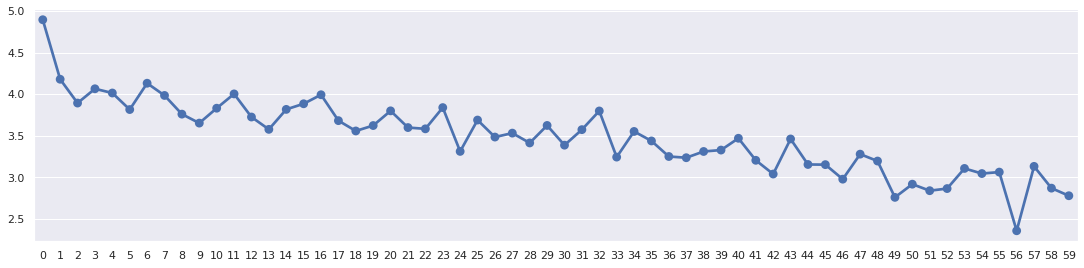

In [51]:
sns.pointplot(x=list(range(len(losses))), y=losses)

In [52]:
inputs = tokenizer(
    """question: what is a witty response to this?
    context: I sold my Kia Soul and bought a guitar and amp. I guess you can say I sold my soul for rock n roll…
    """, 
    padding="max_length", 
    truncation=True,
    return_tensors="pt"
).to(device)

In [53]:
outputs = model.generate(**inputs, temperature=0.99, max_new_tokens=1000)
outputs

tensor([[   0,   27,   31,   51,    3,    9, 2480,    3,   29, 3812, 1819,   11,
            3,    9, 5507, 1819,    5,    1]], device='cuda:0')

In [54]:
tokenizer.batch_decode(outputs, skip_special_tokens=True)

["I'm a rock n roll fan and a guitar fan."]

In [62]:
model.save_pretrained("finetuned-t5-small/")

In [94]:
perplexities = []
for _, example in test_dataset.iterrows():
    input_ids = tokenizer.encode(example['Input'], return_tensors='pt').to(device)
    output_ids = tokenizer.encode(example['Output'], return_tensors='pt').to(device)
    
    with torch.no_grad():
        logits = model(input_ids=input_ids, labels=output_ids).logits
    loss = torch.nn.CrossEntropyLoss()(logits.view(-1, logits.shape[-1]), output_ids.view(-1))
    perplexity = torch.exp(loss)
    perplexities.append(perplexity.item())

Token indices sequence length is longer than the specified maximum sequence length for this model (520 > 512). Running this sequence through the model will result in indexing errors


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='index', ylabel='0'>

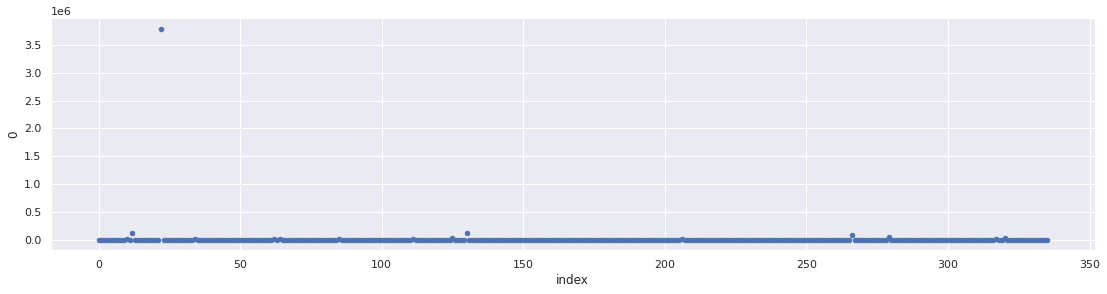

In [95]:
p.reset_index().plot(x="index", y=0, kind="scatter")

In [83]:
p.describe()

count    3.360000e+02
mean     1.304775e+04
std      2.069102e+05
min      4.475823e+00
25%      6.268125e+01
50%      1.046538e+02
75%      2.496999e+02
max      3.789025e+06
dtype: float64

In [74]:
np.mean(perplexities)

13047.753787245068

In [58]:
test_dataset

,Input,Output
0,I saw a dwarf climbing down a prison wall\nIt ...,"""Figured out he was also a psychic...now he i..."
1,After the Titanic completely rusts away there ...,Everyone knows that the Titanic was sunk to d...
2,TIFU / My (20F) girlfriend of two years told m...,This man's literally fucked his girl to robot...
3,Q: What's the secret to telling a good postman...,This joke never works on sundays.
4,Menstruation jokes are not funny and will not ...,I swear this joke comes around every month...
5,My kids refuse to eat leftover tacos for dinne...,And now they are nacho kids
